In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pandas as pd
import tensorflow as tf
import scanpy as sc

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tensorflow_hub as hub

In [1]:
!pip install tensorflow_hub

     |████████████████████████████████| 107 kB 13.9 MB/s eta 0:00:01


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4500385666171242639,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8712895898648000366
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17237823654582704384
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:1"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15953658923972991192
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:2"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4059244625545984836
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:3"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5043201420865586007
 physical_device_desc: "device: XLA_GPU device"]

In [3]:
# imgs = np.load('/data/breast/model_inputs/he_resized.npy')
# X = np.load('/data/breast/model_inputs/he_resized.npy').astype(np.uint8)
adata = sc.read_h5ad('/data/breast/model_inputs/adata.h5ad')
trans_adata = sc.read_h5ad('/data/breast/model_inputs/sctransform_adata.h5ad')
adata.shape, trans_adata.shape

((53217, 36601), (53217, 3000))

In [4]:
train_dir = '/data/breast/model_inputs/he_load_from_dir/train'
val_dir = '/data/breast/model_inputs/he_load_from_dir/val'

In [5]:
def preprocess_img(x):
    return (x / 127.) - 1.

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True,
                                                               preprocessing_function=preprocess_img)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_img)

In [6]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,)
val_generator = val_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,)

Found 36534 images belonging to 12 classes.
Found 36534 images belonging to 12 classes.


In [7]:
train_generator.class_indices
r_ci = {v:k for k, v in train_generator.class_indices.items()}
r_ci

{0: 'B',
 1: 'Basal-Tumor',
 2: 'CAF',
 3: 'CD4-T',
 4: 'DC',
 5: 'Endothelial',
 6: 'LumA-Tumor',
 7: 'LumB-Tumor',
 8: 'Mast',
 9: 'Mono-Macro',
 10: 'Normal-duct',
 11: 'Plasma'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


LumB-Tumor


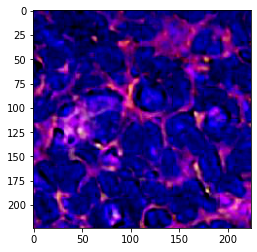

Plasma


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


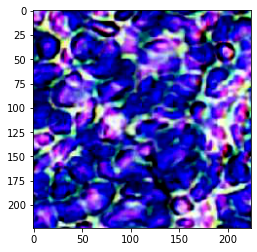

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


LumB-Tumor


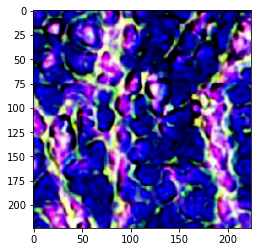

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


LumB-Tumor


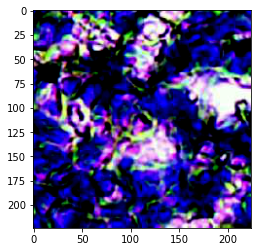

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Basal-Tumor


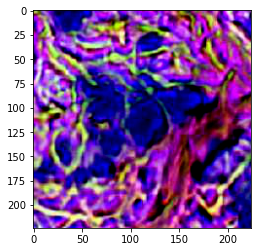

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CAF


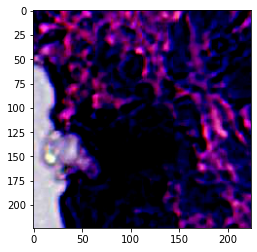

In [8]:
x = None
for image, label in train_generator:
    for i, (img, l) in enumerate(zip(image, label)):
        print(r_ci[np.argmax(l)])
        x = img
        plt.imshow(img)
        plt.show()
        if i == 5: break
    break

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
# rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [11]:
# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

In [12]:
# !pip install h5py==2.10.0

In [13]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [14]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [15]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
# out_layer = tf.keras.layers.Dense(len(encoder.categories_[0]))
# prediction_layer = tf.keras.layers.Softmax()
prediction_layer = tf.keras.Sequential()
prediction_layer.add(tf.keras.layers.Dense(len(train_generator.class_indices)))
prediction_layer.add(tf.keras.layers.Softmax())
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 12)


In [18]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1280)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
train_generator.classes

array([ 0,  0,  0, ..., 11, 11, 11], dtype=int32)

In [20]:
# sklearn.utils.class_weight.compute_class_weight(class_weight, *, classes, y)
from sklearn.utils.class_weight import compute_class_weight
labels = train_generator.classes
weights = compute_class_weight('balanced', sorted(set(labels)), labels)
weights = {i:x for i, x in enumerate(weights)}
weights

/miniconda/envs/spatial/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], y=[ 0  0  0 ... 11 11 11] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


{0: 51.601694915254235,
 1: 1.0545549012816071,
 2: 0.48649728347714927,
 3: 6.58982683982684,
 4: 21.592198581560282,
 5: 1.2246580852775544,
 6: 41.705479452054796,
 7: 0.23653950741978091,
 8: 304.45,
 9: 1.5184538653366584,
 10: 1.6065963060686015,
 11: 0.4121429538378232}

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'],)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1280)              1639680   
_________________________________________________________________
sequential (Sequential)      (None, 12)                15372     
Total params: 3,913,036
Trainable params: 1,655,052
Non-trainable params: 2,257,984
___________________________________________

In [23]:
initial_epochs = 7

loss0, accuracy0 = model.evaluate(val_generator)

  ...
    to  
  ['...']
1142/1142 [==============================] - 203s 178ms/step - loss: 2.7172 - accuracy: 0.0752


In [24]:
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=val_generator,
                    class_weight=weights)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1142 steps, validate for 1142 steps
Epoch 1/7
1142/1142 [==============================] - 399s 349ms/step - loss: 3.0416 - accuracy: 0.1175 - val_loss: 2.2349 - val_accuracy: 0.1107
Epoch 2/7
1142/1142 [==============================] - 388s 340ms/step - loss: 2.8467 - accuracy: 0.1300 - val_loss: 1.9373 - val_accuracy: 0.1798
Epoch 3/7
1142/1142 [==============================] - 384s 336ms/step - loss: 2.3941 - accuracy: 0.1461 - val_loss: 2.2713 - val_accuracy: 0.1032
Epoch 4/7
1142/1142 [==============================] - 381s 334ms/step - loss: 2.3720 - accuracy: 0.1517 - val_loss: 2.0939 - val_accuracy: 0.1257
Epoch 5/7
1142/1142 [==============================] - 384s 336ms/step - loss: 2.1123 - accuracy: 0.1552 - val_loss: 1.8329 - val_accuracy: 0.2426
Epoch 6/7
1142/1142 [==============================] - 381s 334ms/step - loss: 2.1962 - accuracy: 0.1588 - val_loss: 1.8762 - val_accuracy: 0.1313
Epoch 7/7
1142/1142 [=

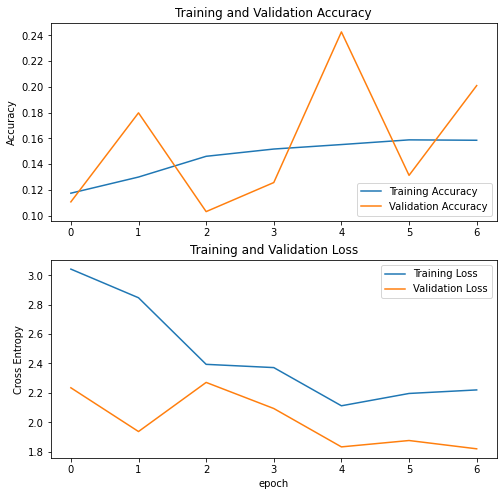

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
base_model.trainable = True

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [28]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/20),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1280)              1639680   
_________________________________________________________________
sequential (Sequential)      (None, 12)                15372     
Total params: 3,913,036
Trainable params: 3,517,644
Non-trainable params: 395,392
_____________________________________________

In [30]:
fine_tune_epochs = 2
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
#                          initial_epoch=history.epoch[-1],
                         validation_data=val_generator,
                         class_weight=weights)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1142 steps, validate for 1142 steps
Epoch 1/9
1142/1142 [==============================] - 454s 398ms/step - loss: 2.0723 - accuracy: 0.1490 - val_loss: 1.8065 - val_accuracy: 0.1549
Epoch 2/9
1142/1142 [==============================] - 447s 391ms/step - loss: 1.9320 - accuracy: 0.1505 - val_loss: 1.8470 - val_accuracy: 0.1830
Epoch 3/9
  31/1142 [..............................] - ETA: 4:07 - loss: 1.4994 - accuracy: 0.1875

KeyboardInterrupt: 

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions = model.predict(X)
predicted_class_names = encoder.categories_[0][np.argmax(predictions, axis=-1)]
predicted_class_names